In [1]:
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18
from copy import deepcopy
import torch.nn.functional as F
from sklearn import linear_model, model_selection
from sklearn.metrics import make_scorer, accuracy_score
from tqdm.notebook import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

from typing import Callable

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)

Running on device: CPU


In [2]:
base_dir = "./Alzheimer_data/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

In [3]:
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

ZOOM = [0.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"
DIM = (224, 224)  # Replace with your desired target size
BATCH_SIZE = 32  # Adjust as needed

In [4]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder

# Assuming you have predefined values for DIM, HORZ_FLIP, ZOOM, BRIGHT_RANGE, BATCH_SIZE, and train_dir

# PyTorch transforms equivalent to Keras ImageDataGenerator
transform = transforms.Compose([
    transforms.Resize(DIM),
    transforms.RandomHorizontalFlip(p=0.5) if HORZ_FLIP else transforms.RandomHorizontalFlip(p=0),
    transforms.RandomAffine(degrees=0, scale=ZOOM, shear=0),
    transforms.ColorJitter(brightness=BRIGHT_RANGE, contrast=(1, 1), saturation=(1, 1), hue=0),
    transforms.ToTensor(),
])

class CustomImageFolderDataset(Dataset):
    def __init__(self, root, transform=None):
        self.image_folder = ImageFolder(root, transform)
        self.num_classes = len(self.image_folder.classes)

    def __len__(self):
        return len(self.image_folder)

    def __getitem__(self, idx):
        img, label = self.image_folder[idx]

        # Convert label to one-hot vector
        one_hot_label = torch.zeros(self.num_classes)
        one_hot_label[label] = 1.0

        return img, one_hot_label

# Dataset and DataLoader
train_dataset = CustomImageFolderDataset(root=train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [5]:
test_dataset = CustomImageFolderDataset(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [6]:
with open('forget_indices.txt', 'r') as file:
    forget_indices = [int(line.strip()) for line in file]

# Print the list for verification
# print("Forget Indices List:", forget_indices)

In [7]:
len(train_dataset)

5121

In [8]:
len(forget_indices)

1025

In [9]:
forget_indices[100]

3390

In [10]:
forget_mask = np.zeros(len(train_dataset), dtype=bool)
forget_mask[forget_indices] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

In [11]:
forget_mask[3390]

True

In [12]:
len(retain_idx)

4096

In [13]:
len(train_dataset)

5121

In [14]:
forget_indices

[672,
 3350,
 1412,
 4992,
 843,
 2132,
 1773,
 72,
 8,
 386,
 1361,
 2645,
 686,
 1959,
 3239,
 4987,
 3569,
 1002,
 1540,
 4283,
 3804,
 610,
 4089,
 1593,
 4169,
 1578,
 814,
 585,
 2837,
 4618,
 4481,
 4564,
 561,
 511,
 325,
 1940,
 601,
 4391,
 549,
 3413,
 4592,
 732,
 2328,
 3255,
 3021,
 2220,
 3604,
 4680,
 2704,
 3202,
 516,
 5064,
 1549,
 2657,
 530,
 1271,
 2860,
 2238,
 4427,
 2032,
 4521,
 1702,
 2492,
 253,
 356,
 3912,
 4606,
 711,
 3132,
 2113,
 4777,
 680,
 2629,
 5065,
 223,
 3550,
 3048,
 3556,
 1219,
 4713,
 78,
 442,
 2389,
 1173,
 4039,
 1974,
 1804,
 5025,
 2714,
 46,
 1696,
 166,
 3505,
 3750,
 3827,
 3331,
 4206,
 2433,
 1491,
 1120,
 3390,
 1438,
 2648,
 1178,
 2958,
 394,
 4220,
 4694,
 3857,
 2298,
 5082,
 3196,
 4828,
 753,
 1246,
 3040,
 865,
 2368,
 2718,
 1906,
 427,
 1699,
 2226,
 3471,
 4240,
 2420,
 1481,
 2119,
 3790,
 3208,
 4065,
 3759,
 3010,
 2363,
 2526,
 4105,
 214,
 690,
 2921,
 1151,
 3694,
 3218,
 1924,
 3888,
 3256,
 3131,
 4301,
 4865,
 

In [15]:
first_sample, first_label = train_dataset[0]

# The first_sample is the image, and first_label is the one-hot encoded label
# You can access the original class label using argmax
class_index = torch.argmax(first_label).item()

# Print information about the first sample
print("Image Shape:", first_sample.shape)
print("Class Index:", class_index)

Image Shape: torch.Size([3, 224, 224])
Class Index: 0


In [16]:
forget_samples = []
forget_labels = []

for idx in forget_indices:
    sample, label = train_dataset[idx]
    forget_samples.append(sample)
    forget_labels.append(label)

# Convert the lists to tensors
forget_samples = torch.stack(forget_samples)
forget_labels = torch.stack(forget_labels)

# Print information about the selected samples
print("Selected Samples Shape:", forget_samples.shape)
print("Selected Labels Shape:", forget_labels.shape)

Selected Samples Shape: torch.Size([1025, 3, 224, 224])
Selected Labels Shape: torch.Size([1025, 4])


In [17]:
import torch
from torch.utils.data import TensorDataset, DataLoader

forget_dataset = TensorDataset(forget_samples, forget_labels)

# Create DataLoader for the selected dataset
forget_loader = DataLoader(forget_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [18]:
for input,label in forget_loader:
    print(input.shape)
    print(label.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32, 4])


In [19]:
retain_samples = []
retain_labels = []

for idx in retain_idx:
    sample, label = train_dataset[idx]
    retain_samples.append(sample)
    retain_labels.append(label)

# Convert the lists to tensors
retain_samples = torch.stack(retain_samples)
retain_labels = torch.stack(retain_labels)

# Print information about the selected samples
print("Selected Samples Shape:", retain_samples.shape)
print("Selected Labels Shape:", retain_labels.shape)

Selected Samples Shape: torch.Size([4096, 3, 224, 224])
Selected Labels Shape: torch.Size([4096, 4])


In [20]:
retain_dataset = TensorDataset(retain_samples, retain_labels)

# Create DataLoader for the selected dataset
retain_loader = DataLoader(retain_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [21]:
import torchvision.models as models
model = models.resnet18(weights=None)

# Replace the last fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

In [22]:
local_path = "origional_model.pth"
weights_pretrained = torch.load(local_path, map_location=DEVICE)

model.load_state_dict(weights_pretrained)
model.to(DEVICE)
model.eval();

In [23]:
import torchvision.models as models
rt_model = models.resnet18(weights=None)

# Replace the last fully connected layer
num_ftrs = rt_model.fc.in_features
rt_model.fc = nn.Linear(num_ftrs, 4)

In [24]:
local_path = "model_retrain.pth"
weights_pretrained = torch.load(local_path, map_location=DEVICE)

rt_model.load_state_dict(weights_pretrained)
rt_model.to(DEVICE)
rt_model.eval();

In [25]:
def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct +=  (predicted == torch.argmax(targets, dim=1)).sum().item()
    return correct / total

print(f"Train set accuracy on origional model: {100.0 * accuracy(model, train_loader):0.1f}%")
print(f"Test set accuracy on origional model: {100.0 * accuracy(model, test_loader):0.1f}%")
print(f"Forget set accuracy on origional model: {100.0 * accuracy(model, forget_loader):0.1f}%")

Train set accuracy on origional model: 98.0%
Test set accuracy on origional model: 67.6%
Forget set accuracy on origional model: 98.1%


In [26]:
print(f"Retain set accuracy on retrain model: {100.0 * accuracy(rt_model, retain_loader):0.1f}%")
print(f"Forget set accuracy on retrain model: {100.0 * accuracy(rt_model, forget_loader):0.1f}%")
print(f"Test set accuracy on retrain model: {100.0 * accuracy(rt_model, test_loader):0.1f}%")

Retain set accuracy on retrain model: 97.9%
Forget set accuracy on retrain model: 98.1%
Test set accuracy on retrain model: 69.8%


In [27]:
def unlearning(net, retain, forget, validation):
    """Unlearning by fine-tuning.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      net : nn.Module.
        pre-trained model to use as base of unlearning.
      retain : torch.utils.data.DataLoader.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      forget : torch.utils.data.DataLoader.
        Dataset loader for access to the forget set. This is the subset
        of the training set that we want to forget. This method doesn't
        make use of the forget set.
      validation : torch.utils.data.DataLoader.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      net : updated model
    """
    epochs = 5

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    net.train()

    for _ in range(epochs):
        for inputs, targets in retain:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

    net.eval()
    return net

In [28]:
data_loaders = {
    "retain" : retain_loader,
    "forget" : forget_loader,
    "testing" : test_loader
}

In [29]:
pretrained_models = {
    "original" : model,
    "retrained" : rt_model
}

In [30]:
def compute_outputs(net, loader):
    """Auxiliary function to compute the logits for all datapoints.
    Does not shuffle the data, regardless of the loader.
    """

    # Make sure loader does not shuffle the data
    if isinstance(loader.sampler, torch.utils.data.sampler.RandomSampler):
        loader = DataLoader(
            loader.dataset, 
            batch_size=loader.batch_size, 
            shuffle=False, 
            num_workers=loader.num_workers)
    
    all_outputs = []
    all_targets = []
    
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to("cpu")

        logits = net(inputs).detach().cpu().numpy() # (batch_size, num_classes)
        
        all_outputs.append(logits)
        all_targets.extend(targets)
        
    return np.array(all_targets), np.concatenate(all_outputs) # (len(loader.dataset), num_classes)

In [31]:
def cross_entropy_f(x, targets):
    # Convert NumPy array to PyTorch tensor
    x_tensor = torch.from_numpy(x)

    # Apply softmax to the model output
    x_softmax = F.softmax(x_tensor, dim=-1)

    # Convert targets to one-hot encoding
    targets_tensor = torch.from_numpy(targets)
    targets_one_hot = targets_tensor
    # targets_one_hot = F.one_hot(targets_tensor, num_classes=4)

    # Avoiding NaN values in x
    x_tensor[torch.isnan(x_tensor)] = 0.0

    # Calculate cross-entropy loss for each example
    loss = -torch.sum(targets_one_hot * torch.log(x_softmax), dim=-1)

    # Convert the result back to a NumPy array if needed
    loss_np = loss.numpy()

    return loss_np
    

In [32]:
def false_positive_rate(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Computes the false positive rate (FPR)."""
    fp = np.sum(np.logical_and((y_pred == 1), (y_true == 0)))
    n = np.sum(y_true == 0)
    return fp / n


def false_negative_rate(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Computes the false negative rate (FNR)."""
    fn = np.sum(np.logical_and((y_pred == 0), (y_true == 1)))
    p = np.sum(y_true == 1)
    return fn / p


# The SCORING dictionary is used by sklearn's `cross_validate` function so that
# we record the FPR and FNR metrics of interest when doing cross validation
SCORING = {
    'false_positive_rate': make_scorer(false_positive_rate),
    'false_negative_rate': make_scorer(false_negative_rate)
}


def logistic_regression_attack(
        outputs_U, outputs_R, n_splits=2, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      outputs_U: numpy array of shape (N)
      outputs_R: numpy array of shape (N)
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      fpr, fnr : float * float
    """
    assert len(outputs_U) == len(outputs_R)
    
    samples = np.concatenate((outputs_R, outputs_U)).reshape((-1, 1))
    labels = np.array([0] * len(outputs_R) + [1] * len(outputs_U))

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    scores =  model_selection.cross_validate(
        attack_model, samples, labels, cv=cv, scoring=SCORING)
    
    fpr = np.mean(scores["test_false_positive_rate"])
    fnr = np.mean(scores["test_false_negative_rate"])
    
    return fpr, fnr

In [33]:
def compute_epsilon_s(fpr: list[float], fnr: list[float], delta: float) -> float:
    """Computes the privacy degree (epsilon) of a particular forget set example, 
    given the FPRs and FNRs resulting from various attacks.
    
    The smaller epsilon is, the better the unlearning is.
    
    Args:
      fpr: list[float] of length m = num attacks. The FPRs for a particular example. 
      fnr: list[float] of length m = num attacks. The FNRs for a particular example.
      delta: float
    Returns:
      epsilon: float corresponding to the privacy degree of the particular example.
    """
    assert len(fpr) == len(fnr)
    
    per_attack_epsilon = [0.]
    for fpr_i, fnr_i in zip(fpr, fnr):
        if fpr_i == 0 and fnr_i == 0:
            per_attack_epsilon.append(np.inf)
        elif fpr_i == 0 or fnr_i == 0:
            pass # discard attack
        else:
            with np.errstate(invalid='ignore'):
                epsilon1 = np.log(1. - delta - fpr_i) - np.log(fnr_i)
                epsilon2 = np.log(1. - delta - fnr_i) - np.log(fpr_i)
            if np.isnan(epsilon1) and np.isnan(epsilon2):
                per_attack_epsilon.append(np.inf)
            else:
                per_attack_epsilon.append(np.nanmax([epsilon1, epsilon2]))
            
    return np.nanmax(per_attack_epsilon)


def bin_index_fn(
        epsilons: np.ndarray, 
        bin_width: float = 0.5, 
        B: int = 13
        ) -> np.ndarray:
    """The bin index function."""
    bins = np.arange(0, B) * bin_width
    return np.digitize(epsilons, bins)


def H(epsilons: np.ndarray) -> float:
    """Computes the forgetting quality given the privacy degrees 
    of the forget set examples.
    """
    ns = bin_index_fn(epsilons)
    hs = 2. / 2 ** ns
    return np.mean(hs)

In [34]:
def forgetting_quality(
        outputs_U: np.ndarray, # (N, S)
        outputs_R: np.ndarray, # (N, S)
        attacks: list[Callable] = [logistic_regression_attack],
        delta: float = 0.01
    ):
    """
    Both `outputs_U` and `outputs_R` are of numpy arrays of ndim 2:
    * 1st dimension coresponds to the number of samples obtained from the 
      distribution of each model (N=512 in the case of the competition's leaderboard) 
    * 2nd dimension corresponds to the number of samples in the forget set (S).
    """
    
    # N = number of model samples
    # S = number of forget samples
    N, S = outputs_U.shape
    
    assert outputs_U.shape == outputs_R.shape, \
        "unlearn and retrain outputs need to be of the same shape"
    
    epsilons = []
    pbar = tqdm(range(S))
    for sample_id in range(S):
        print("Current sample_id is ",sample_id)
        # pbar.set_description("Computing F...")
        
        sample_fprs, sample_fnrs = [], []
        
        for attack in attacks: 
            uls = outputs_U[:, sample_id]
            rls = outputs_R[:, sample_id]
            
            fpr, fnr = attack(uls, rls)
            
            if isinstance(fpr, list):
                sample_fprs.extend(fpr)
                sample_fnrs.extend(fnr)
            else:
                sample_fprs.append(fpr)
                sample_fnrs.append(fnr)
        
        sample_epsilon = compute_epsilon_s(sample_fprs, sample_fnrs, delta=delta)
        epsilons.append(sample_epsilon)
        
    return H(np.array(epsilons))

In [35]:
def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct +=  (predicted == torch.argmax(targets, dim=1)).sum().item()
    return correct / total

In [36]:
## This snippet is taken is provided by the orgamnizers of kaggle competition as a startup script.

def score_unlearning_algorithm(
        data_loaders: dict, 
        pretrained_models: dict, 
        unlearning: Callable, 
        n: int = 10,
        delta: float = 0.01,
        f: Callable = cross_entropy_f,
        attacks: list[Callable] = [logistic_regression_attack]
        ) -> dict:
    
    retain_loader = data_loaders["retain"]
    forget_loader = data_loaders["forget"]
    # val_loader = data_loaders["validation"]
    test_loader = data_loaders["testing"]
    
    original_model = pretrained_models["original"]
    rt_model = pretrained_models["retrained"]
    
    outputs_U = []
    outputs_R = []
    retain_accuracy = []
    test_accuracy = []
    forget_accuracy = []
    
    u_model = deepcopy(original_model)
    for i in range(n):
        print("Running epoch :",i+1)
        
        print("I am now unlearning all the wrong things you taught me!!!")
        
        u_model = unlearning(u_model, retain_loader, forget_loader, test_loader)
        
        targets, outputs_Ui = compute_outputs(u_model, forget_loader)
        
#         print(targets.shape)
#         f_forget = f(outputs_Ui, targets)
#         print(f_forget.shape)
        
        outputs_U.append( f(outputs_Ui, targets) )

        has_nan_values = np.isnan(np.array(outputs_U)).any()

        if has_nan_values:
            print("outputs_U contains NaN values.")
        
        else:
            print("outputs_U does not contain NaN values.")
        
        print("Computing retain accuracy on Unlearning Model")
        acc = accuracy(u_model, retain_loader)
        print("Retain accuracy on Unlearning Model is ",acc)
        retain_accuracy.append(acc)
        
        print("Computing test accuracy on Unlearning model")
        acc = accuracy(u_model, test_loader)
        print("Test accuracy on Unlearning model is ", acc)
        test_accuracy.append(acc)
        
        print("Computing forget accuracy on Unlearning model")
        acc = accuracy(u_model, forget_loader)
        print("Forget accuracy on Unlearning model is ",acc)
        forget_accuracy.append(acc)
        
    outputs_U = np.array(outputs_U)
    print("Printing outputs_U shape ",outputs_U.shape)
#     print(outputs_U.shape)
    
    assert outputs_U.shape == (n, len(forget_loader.dataset)),\
        "Wrong shape for outputs_U. Should be (num_model_samples, num_forget_datapoints)."
    
    RAR = accuracy(rt_model, retain_loader)
    TAR = accuracy(rt_model, test_loader)
    FAR = accuracy(rt_model, forget_loader)
    
    RAU = np.mean(retain_accuracy)
    TAU = np.mean(test_accuracy)
    FAU = np.mean(forget_accuracy)
    
    RA_ratio = RAU / RAR
    TA_ratio = TAU / TAR
    
    for i in range(n):
        targets, outputs_Ri = compute_outputs(rt_model, forget_loader) #(len(forget_loader.dataset), 10) 
        
        outputs_R.append(f(outputs_Ri, targets) )
    
    outputs_R = np.array(outputs_R)
    print("Printing outputs_R shape ",outputs_R.shape)
    
    f = forgetting_quality(
    outputs_U, 
    outputs_R,
    attacks=attacks,
    delta=delta)
    
    return {
        "total_score": f * RA_ratio * TA_ratio,
        "F": f,
        "unlearn_retain_accuracy": RAU,
        "unlearn_test_accuracy": TAU, 
        "unlearn_forget_accuracy": FAU,
        "retrain_retain_accuracy": RAR,
        "retrain_test_accuracy": TAR, 
        "retrain_forget_accuracy": FAR,
        "retrain_outputs": outputs_R,
        "unlearn_outputs": outputs_U,
        "unlearning_model": u_model
    }

In [37]:
ret = score_unlearning_algorithm(data_loaders, pretrained_models,unlearning,10,0.01,cross_entropy_f)

Running epoch : 1
I am now unlearning all the wrong things you taught me!!!
outputs_U does not contain NaN values.
Computing retain accuracy on Unlearning Model
Retain accuracy on Unlearning Model is  0.556640625
Computing test accuracy on Unlearning model
Test accuracy on Unlearning model is  0.54573885848319
Computing forget accuracy on Unlearning model
Forget accuracy on Unlearning model is  0.5648780487804878
Running epoch : 2
I am now unlearning all the wrong things you taught me!!!
outputs_U does not contain NaN values.
Computing retain accuracy on Unlearning Model
Retain accuracy on Unlearning Model is  0.570068359375
Computing test accuracy on Unlearning model
Test accuracy on Unlearning model is  0.5605942142298671
Computing forget accuracy on Unlearning model
Forget accuracy on Unlearning model is  0.5648780487804878
Running epoch : 3
I am now unlearning all the wrong things you taught me!!!
outputs_U does not contain NaN values.
Computing retain accuracy on Unlearning Model


  0%|          | 0/1025 [00:00<?, ?it/s]

Current sample_id is  0
Current sample_id is  1
Current sample_id is  2
Current sample_id is  3
Current sample_id is  4
Current sample_id is  5
Current sample_id is  6
Current sample_id is  7
Current sample_id is  8
Current sample_id is  9
Current sample_id is  10
Current sample_id is  11
Current sample_id is  12
Current sample_id is  13
Current sample_id is  14
Current sample_id is  15
Current sample_id is  16
Current sample_id is  17
Current sample_id is  18
Current sample_id is  19
Current sample_id is  20
Current sample_id is  21
Current sample_id is  22
Current sample_id is  23
Current sample_id is  24
Current sample_id is  25
Current sample_id is  26
Current sample_id is  27
Current sample_id is  28
Current sample_id is  29
Current sample_id is  30
Current sample_id is  31
Current sample_id is  32
Current sample_id is  33
Current sample_id is  34
Current sample_id is  35
Current sample_id is  36
Current sample_id is  37
Current sample_id is  38
Current sample_id is  39
Current sa

In [38]:
ret

{'total_score': 0.180195395948956,
 'F': 0.26944669397865856,
 'unlearn_retain_accuracy': 0.79638671875,
 'unlearn_test_accuracy': 0.5710711493354184,
 'unlearn_forget_accuracy': 0.7358048780487805,
 'retrain_retain_accuracy': 0.9794921875,
 'retrain_test_accuracy': 0.6942924159499609,
 'retrain_forget_accuracy': 0.9814634146341463,
 'retrain_outputs': array([[2.4706819e-03, 2.1324228e-03, 2.8849065e-05, ..., 7.8771198e-03,
         2.1704407e-04, 1.0077665e-03],
        [2.4706819e-03, 2.1324228e-03, 2.8849065e-05, ..., 7.8771198e-03,
         2.1704407e-04, 1.0077665e-03],
        [2.4706819e-03, 2.1324228e-03, 2.8849065e-05, ..., 7.8771198e-03,
         2.1704407e-04, 1.0077665e-03],
        ...,
        [2.4706819e-03, 2.1324228e-03, 2.8849065e-05, ..., 7.8771198e-03,
         2.1704407e-04, 1.0077665e-03],
        [2.4706819e-03, 2.1324228e-03, 2.8849065e-05, ..., 7.8771198e-03,
         2.1704407e-04, 1.0077665e-03],
        [2.4706819e-03, 2.1324228e-03, 2.8849065e-05, ..., 7.87

In [39]:
ut_model = ret["unlearning_model"]
def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


ut_train_losses = compute_losses(ut_model, train_loader)
ut_test_losses = compute_losses(ut_model, test_loader)
ut_forget_losses = compute_losses(ut_model, forget_loader)

In [40]:
rt_train_losses = compute_losses(rt_model, train_loader)
rt_test_losses = compute_losses(rt_model, test_loader)
rt_forget_losses = compute_losses(rt_model, forget_loader)

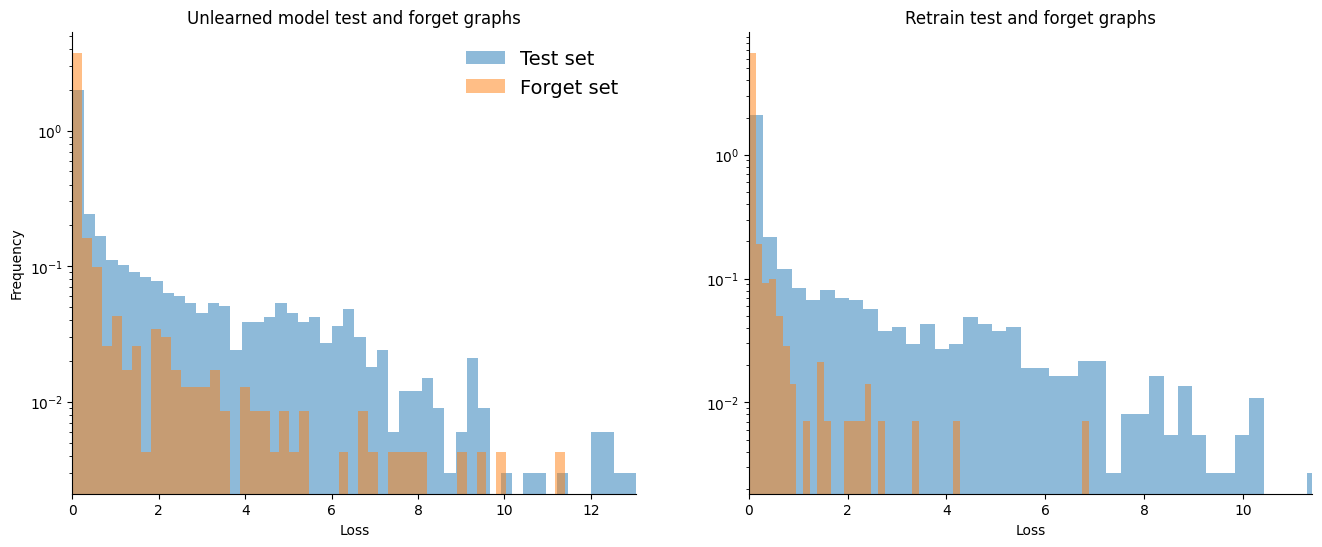

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Unlearned model test and forget graphs")
ax1.hist(ut_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(ut_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Retrain test and forget graphs"
)
ax2.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(ut_test_losses)))
ax2.set_xlim((0, np.max(ut_forget_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

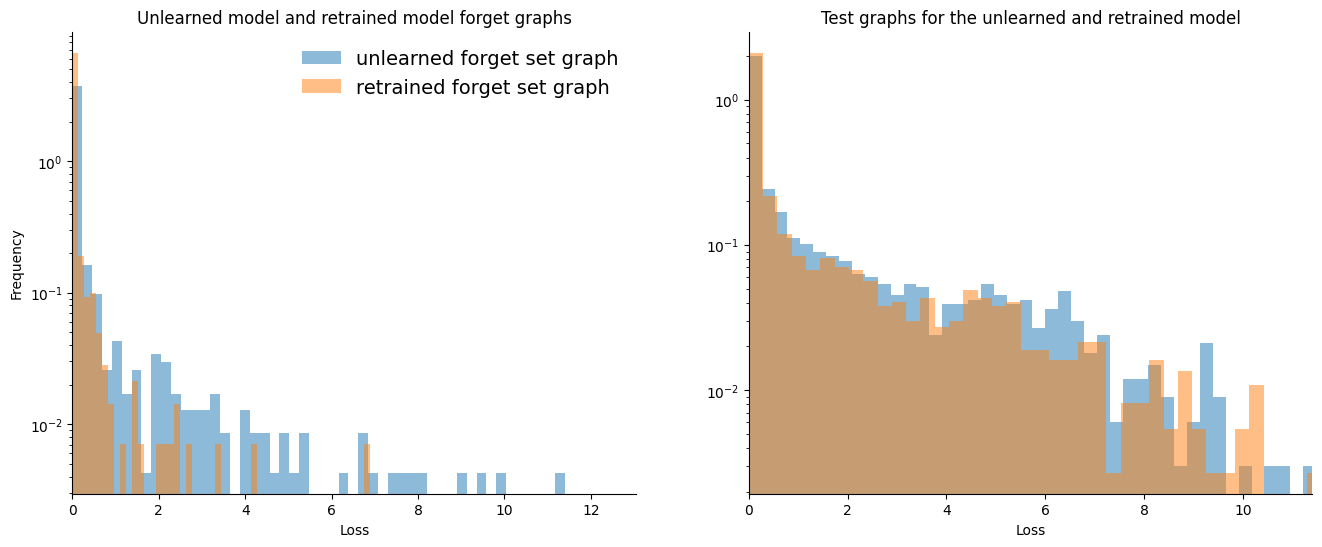

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Unlearned model and retrained model forget graphs")
ax1.hist(ut_forget_losses, density=True, alpha=0.5, bins=50, label="unlearned forget set graph")
ax1.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="retrained forget set graph")

ax2.set_title(
    f"Test graphs for the unlearned and retrained model"
)
ax2.hist(ut_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(ut_test_losses)))
ax2.set_xlim((0, np.max(ut_forget_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()